In [1]:
!nvidia-smi

Wed Jul 20 02:32:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# check files
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
# dev.txt is for validation

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

In [6]:
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list

  Args;
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [8]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data

  Takes in filename, reads it contents sorts through each line, 
  extracting things lile the target label, the text of the sentence,
  how many sentences are in the scuurent abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else: # in this case, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 587 ms, sys: 109 ms, total: 697 ms
Wall time: 1.01 s


In [10]:
train_samples[:13]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

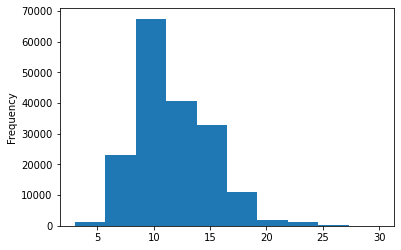

In [13]:
train_df.total_lines.plot.hist()

### Get lists of sentences

In [14]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [16]:
# one hot eoncode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## A series of modelling experiments

## Model 0 Baseline

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("ft-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('ft-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [21]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
# Get helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-20 02:32:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-20 02:32:53 (99.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results

baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [25]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([2.5486e+04, 7.1478e+04, 4.8888e+04, 2.0260e+04, 7.5560e+03,
        3.4370e+03, 1.4950e+03, 7.3700e+02, 3.2800e+02, 1.6500e+02,
        8.5000e+01, 4.9000e+01, 2.0000e+01, 1.5000e+01, 9.0000e+00,
        6.0000e+00, 8.0000e+00, 8.0000e+00, 3.0000e+00, 2.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1. ,  12.8,  24.6,  36.4,  48.2,  60. ,  71.8,  83.6,  95.4,
        107.2, 119. , 130.8, 142.6, 154.4, 166.2, 178. , 189.8, 201.6,
        213.4, 225.2, 237. , 248.8, 260.6, 272.4, 284.2, 296. ]),
 <a list of 25 Patch objects>)

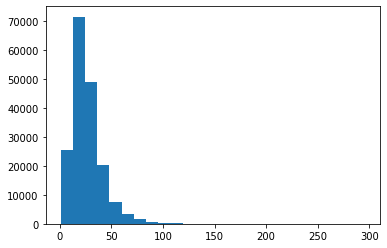

In [26]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 25)

In [27]:
# 95% of sentence length
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [28]:
# Max length
max(sent_lens)

296

### Create text vectorizer layer

In [29]:
max_tokens = 68000

In [30]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=output_seq_len)

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
import random# Text text vecotrizer

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
the only significant difference we observed was between the self-etching fluoride-releasing primer ( group c ) and traditional etching ( group d ) at the final assessment ( t@ ) .

Length of text: 31

Vectorized text: [[    2   192    37    74    43   148    10    30     2 16583 15995 11448
     13   243     3   803 14995    13   187    15     2   816   250   206
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [33]:
# how many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Text embedding

In [35]:
from tensorflow.keras import layers

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim=128,
                             mask_zero=True,
                             name="token_embedding")

In [36]:
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 the only significant difference we observed was between the self-etching fluoride-releasing primer ( group c ) and traditional etching ( group d ) at the final assessment ( t@ ) .

Sentence after vectorization (before embedding):
 [[    2   192    37    74    43   148    10    30     2 16583 15995 11448
     13   243     3   803 14995    13   187    15     2   816   250   206
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.04386727 -0.02772697 -0.04818257 ... -0.03040751  0.04902902
    0.03570599]
  [-0.04335464 -0.01327246 -0.01153319 ...  0.01535399  0.0337964
   -0.0110452 ]
  [-0.04120922  0.00635751 -0.01213489 ... -0.03611137 -0.04427293
    0.00832874]
  ...
  [-0.03169495 -0.00928984  0.02895677 ...  0.01652073 -0.01345503
   -0.01796616]
  [-0.03169495 -0.00928984  0.

## Creating datasets

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [38]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
train_labels_one_hot.shape

(180040, 5)

In [40]:
# Take data and prefetch
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [41]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 : Conv1D

In [42]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
toekn_embeddings = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="same")(toekn_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [43]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [44]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.9116 - accuracy: 0.6411 - val_loss: 0.6792 - val_accuracy: 0.7394
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6538 - accuracy: 0.7587 - val_loss: 0.6257 - val_accuracy: 0.7726
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6149 - accuracy: 0.7751 - val_loss: 0.5963 - val_accuracy: 0.7849


In [45]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5978 - accuracy: 0.7858


[0.597843587398529, 0.7857804894447327]

In [46]:
# make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.41628695e-01, 1.72191814e-01, 6.26950637e-02, 3.03323954e-01,
         2.01604683e-02],
        [4.45750624e-01, 2.66812384e-01, 1.63949430e-02, 2.59969205e-01,
         1.10728526e-02],
        [1.46601453e-01, 4.18590475e-03, 1.26192113e-03, 8.47909331e-01,
         4.13003945e-05],
        ...,
        [3.86042848e-06, 7.48820952e-04, 4.89136379e-04, 3.03495563e-06,
         9.98755097e-01],
        [5.68141378e-02, 4.44552451e-01, 1.07189395e-01, 6.96205944e-02,
         3.21823418e-01],
        [1.72708243e-01, 7.04469860e-01, 4.16373573e-02, 4.01245765e-02,
         4.10599075e-02]], dtype=float32), (30212, 5))

In [47]:
# convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.57804845756652,
 'f1': 0.7833233548492337,
 'precision': 0.7829560147287816,
 'recall': 0.7857804845756653}

## Model 2 : Feature Extractor

In [49]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [50]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 cost of treatment and lost productivity ranged from $ @ for @ smt sessions to $ @ for @ smt sessions with no statistically significant differences between groups .
Sentence after embedding:
 [ 0.02821274  0.00894147 -0.04743686  0.01972661  0.04404726  0.05845832
 -0.06524471 -0.05627179  0.0287213  -0.05823877  0.05169616 -0.06339697
 -0.0778345   0.01190846 -0.0489367   0.04556605 -0.04145985  0.01843975
  0.01684319 -0.0210878  -0.01666308  0.08080242 -0.01058435 -0.07744621
 -0.00996713 -0.00211736  0.01104491 -0.04128187  0.00170849 -0.03891059]

Length of sentence embedding: 512


In [51]:
# tf_hub_embedding_layer.trainable= True

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

In [52]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [54]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 17ms/step - loss: 0.9178 - accuracy: 0.6512 - val_loss: 0.7936 - val_accuracy: 0.6935
Epoch 2/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7660 - accuracy: 0.7022 - val_loss: 0.7503 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7473 - accuracy: 0.7139 - val_loss: 0.7332 - val_accuracy: 0.7178


In [55]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7362 - accuracy: 0.7162


[0.7361764907836914, 0.7162054777145386]

In [56]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.1975129e-01, 3.6814076e-01, 2.4180983e-03, 2.0155048e-01,
        8.1393225e-03],
       [3.3530068e-01, 5.0744677e-01, 3.6840544e-03, 1.5075549e-01,
        2.8129849e-03],
       [2.2799504e-01, 1.6518056e-01, 1.5284048e-02, 5.5572158e-01,
        3.5818752e-02],
       ...,
       [1.5767734e-03, 6.1944737e-03, 5.2396771e-02, 8.3215447e-04,
        9.3899989e-01],
       [4.3209554e-03, 4.6407990e-02, 2.0923242e-01, 1.4941341e-03,
        7.3854452e-01],
       [1.7683040e-01, 2.7542171e-01, 4.8004463e-01, 1.0076346e-02,
        5.7626840e-02]], dtype=float32)

In [57]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [58]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

In [59]:
model_2_results

{'accuracy': 71.62054812657223,
 'f1': 0.7131358454596889,
 'precision': 0.7164743864480473,
 'recall': 0.7162054812657223}

## Model 3 : Conv1D with character embeddings

In [60]:
# Character-level tokenizer
def split_chars(text):
  return " ".join(list(text))

In [61]:
split_chars(random_train_sentence)

'c o s t   o f   t r e a t m e n t   a n d   l o s t   p r o d u c t i v i t y   r a n g e d   f r o m   $   @   f o r   @   s m t   s e s s i o n s   t o   $   @   f o r   @   s m t   s e s s i o n s   w i t h   n o   s t a t i s t i c a l l y   s i g n i f i c a n t   d i f f e r e n c e s   b e t w e e n   g r o u p s   .'

In [62]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [63]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

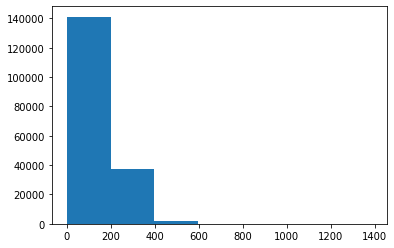

In [64]:
# check the distribution
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [65]:
# Find what charcter length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [66]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [67]:
# create char_level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and Out Of Vocab token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                   output_sequence_length=output_seq_char_len,
                                   # standardize=None,
                                   name="char_vectorizer")

In [68]:
char_vectorizer.adapt(train_chars)

In [69]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common charcters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common charcters: ['k', 'x', 'z', 'q', 'j']


In [70]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars:\n {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vecotrized chars: {len(vectorized_chars[0])}")

Charified text:
 a s   c o m p a r e d   w i t h   c l o m i p h e n e   ,   l e t r o z o l e   w a s   a s s o c i a t e d   w i t h   h i g h e r   l i v e - b i r t h   a n d   o v u l a t i o n   r a t e s   a m o n g   i n f e r t i l e   w o m e n   w i t h   t h e   p o l y c y s t i c   o v a r y   s y n d r o m e   .
Length of random_train_chars:
 134

Vectorized chars:
 [[ 5  9 11  7 15 14  5  8  2 10 20  4  3 13 11 12  7 15  4 14 13  2  6  2
  12  2  3  8  7 25  7 12  2 20  5  9  5  9  9  7 11  4  5  3  2 10 20  4
   3 13 13  4 18 13  2  8 12  4 21  2 22  4  8  3 13  5  6 10  7 21 16 12
   5  3  4  7  6  8  5  3  2  9  5 15  7  6 18  4  6 17  2  8  3  4 12  2
  20  7 15  2  6 20  4  3 13  3 13  2 14  7 12 19 11 19  9  3  4 11  7 21
   5  8 19  9 19  6 10  8  7 15  2  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  

### Character level embedding

In [71]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

In [72]:
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 a s   c o m p a r e d   w i t h   c l o m i p h e n e   ,   l e t r o z o l e   w a s   a s s o c i a t e d   w i t h   h i g h e r   l i v e - b i r t h   a n d   o v u l a t i o n   r a t e s   a m o n g   i n f e r t i l e   w o m e n   w i t h   t h e   p o l y c y s t i c   o v a r y   s y n d r o m e   .

Embedded chars (after vectorization and embedding):
 [[[-0.04583471  0.03314051 -0.00706359 ... -0.04531751  0.01266091
    0.03115847]
  [-0.03480966  0.02422942 -0.04727217 ...  0.04063891  0.03714957
    0.04514487]
  [ 0.03929638  0.02421787 -0.03590416 ...  0.04237672 -0.0458337
   -0.0374694 ]
  ...
  [-0.00884992  0.01282127 -0.01854899 ...  0.00066123  0.04027209
    0.02749083]
  [-0.00884992  0.01282127 -0.01854899 ...  0.00066123  0.04027209
    0.02749083]
  [-0.00884992  0.01282127 -0.01854899 ...  0.00066123  0.04027209
    0.02749083]]]
Character embedding shape: (1, 290, 25)


In [73]:
# Model3
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="same")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1D_char_embeddings")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [74]:
model_3.summary()

Model: "model_3_conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [75]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [77]:
model_3_history = model_3.fit(train_char_dataset,
                  steps_per_epoch=int(0.1*len(train_char_dataset)),
                  epochs=3,
                  validation_data=val_char_dataset,
                  validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2611 - accuracy: 0.4850 - val_loss: 1.0494 - val_accuracy: 0.5798
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0217 - accuracy: 0.5907 - val_loss: 0.9486 - val_accuracy: 0.6303
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9371 - accuracy: 0.6293 - val_loss: 0.8745 - val_accuracy: 0.6639


In [78]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.2419046 , 0.38411692, 0.07999115, 0.24378103, 0.05020637],
       [0.06804983, 0.69304675, 0.0247775 , 0.16364913, 0.05047678],
       [0.16389099, 0.2364269 , 0.27783087, 0.30358982, 0.0182614 ],
       ...,
       [0.02492834, 0.0303674 , 0.15994754, 0.03602166, 0.748735  ],
       [0.02843768, 0.07872404, 0.37478063, 0.0244964 , 0.49356127],
       [0.4041843 , 0.42312253, 0.08783255, 0.06330542, 0.02155521]],
      dtype=float32)

In [79]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [80]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

In [81]:
model_3_results

{'accuracy': 65.40116509996028,
 'f1': 0.6445095291623466,
 'precision': 0.6455420377740375,
 'recall': 0.6540116509996028}

## Model 4 : Combining pretrained token embeddings + characters embeddings

In [82]:
# Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# Setupt char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Concatenate token and char inputs
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Construct model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_toekn_and_char_embeddings")

In [83]:
model_4.summary()

Model: "model_4_toekn_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

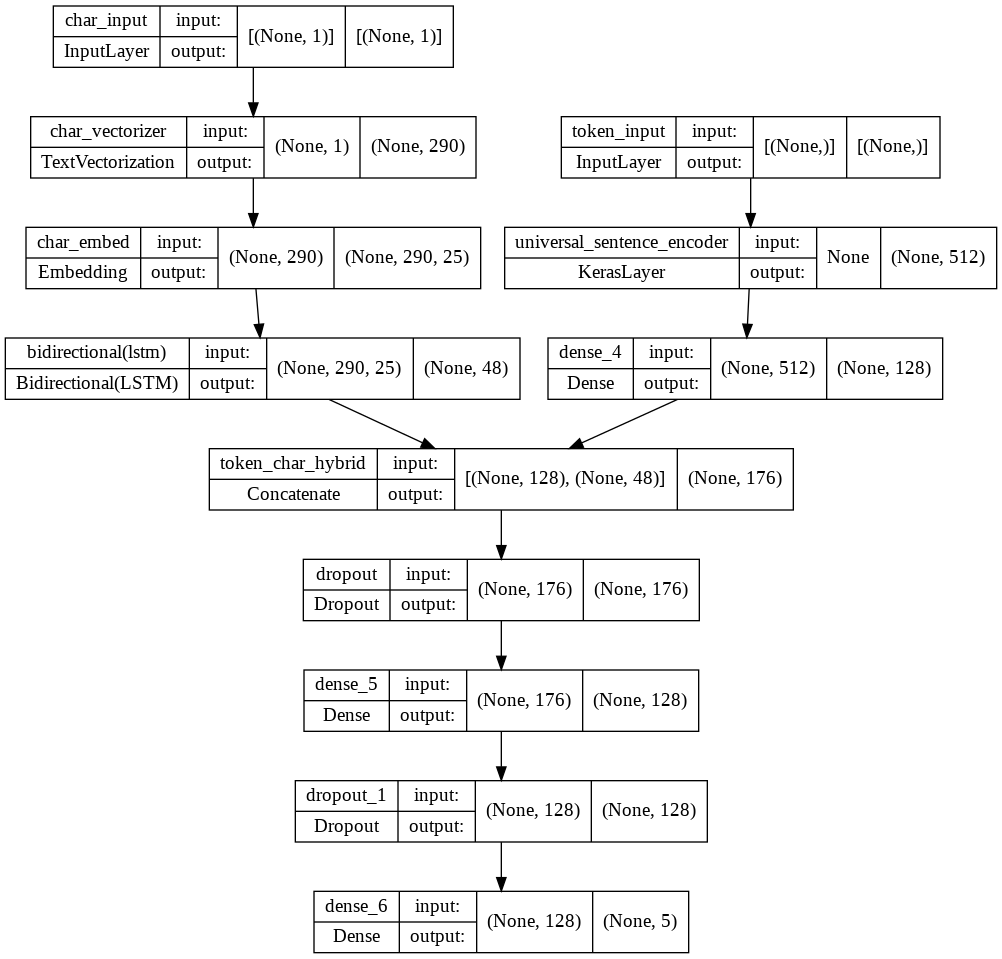

In [84]:
# Plot model
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [85]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into tf.data Dataset

In [86]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # order must be the same as the model
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [87]:
# validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [88]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [89]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 56ms/step - loss: 0.9908 - accuracy: 0.6028 - val_loss: 0.7798 - val_accuracy: 0.7015
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.8022 - accuracy: 0.6934 - val_loss: 0.7220 - val_accuracy: 0.7247
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.7788 - accuracy: 0.7061 - val_loss: 0.6867 - val_accuracy: 0.7404


In [90]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 25s 26ms/step - loss: 0.6916 - accuracy: 0.7371


[0.691643238067627, 0.7371243238449097]

In [91]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.59353387e-01, 3.43396366e-01, 7.01067131e-03, 1.80449262e-01,
        9.79031436e-03],
       [3.34779620e-01, 5.06498337e-01, 6.13806210e-03, 1.49913579e-01,
        2.67042592e-03],
       [2.75886118e-01, 1.79696143e-01, 4.65673544e-02, 4.48388785e-01,
        4.94616032e-02],
       ...,
       [3.59322148e-04, 7.18476065e-03, 4.58030254e-02, 1.10430716e-04,
        9.46542501e-01],
       [7.13985506e-03, 5.00514731e-02, 2.70714700e-01, 2.98810704e-03,
        6.69105828e-01],
       [3.35317552e-01, 3.14441711e-01, 2.49884218e-01, 5.63819073e-02,
        4.39746790e-02]], dtype=float32)

In [92]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [93]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)

In [94]:
model_4_results

{'accuracy': 73.71243214616709,
 'f1': 0.7338045306006993,
 'precision': 0.7362338508432399,
 'recall': 0.7371243214616708}

## Model 5 : positional embeddings

In [95]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

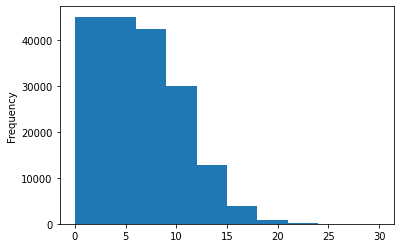

In [96]:
train_df.line_number.plot.hist()

In [97]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [98]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

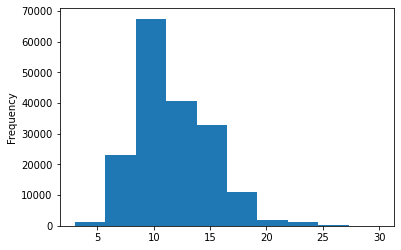

In [99]:
train_df.total_lines.plot.hist()

In [100]:
np.percentile(train_df.total_lines, 95)

18.0

In [101]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [102]:
train_line_numbers_one_hot[0].shape

TensorShape([15])

In [103]:
train_total_lines_one_hot[0].shape

TensorShape([20])

In [104]:
# tribrid model

# Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Line number model
line_number_inputs = layers.Input(shape=(15,), dtype="float32", name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype="float32", name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# combine token and char embeddings
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])
# output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# make a model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding")

In [105]:
model_5.summary()

Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

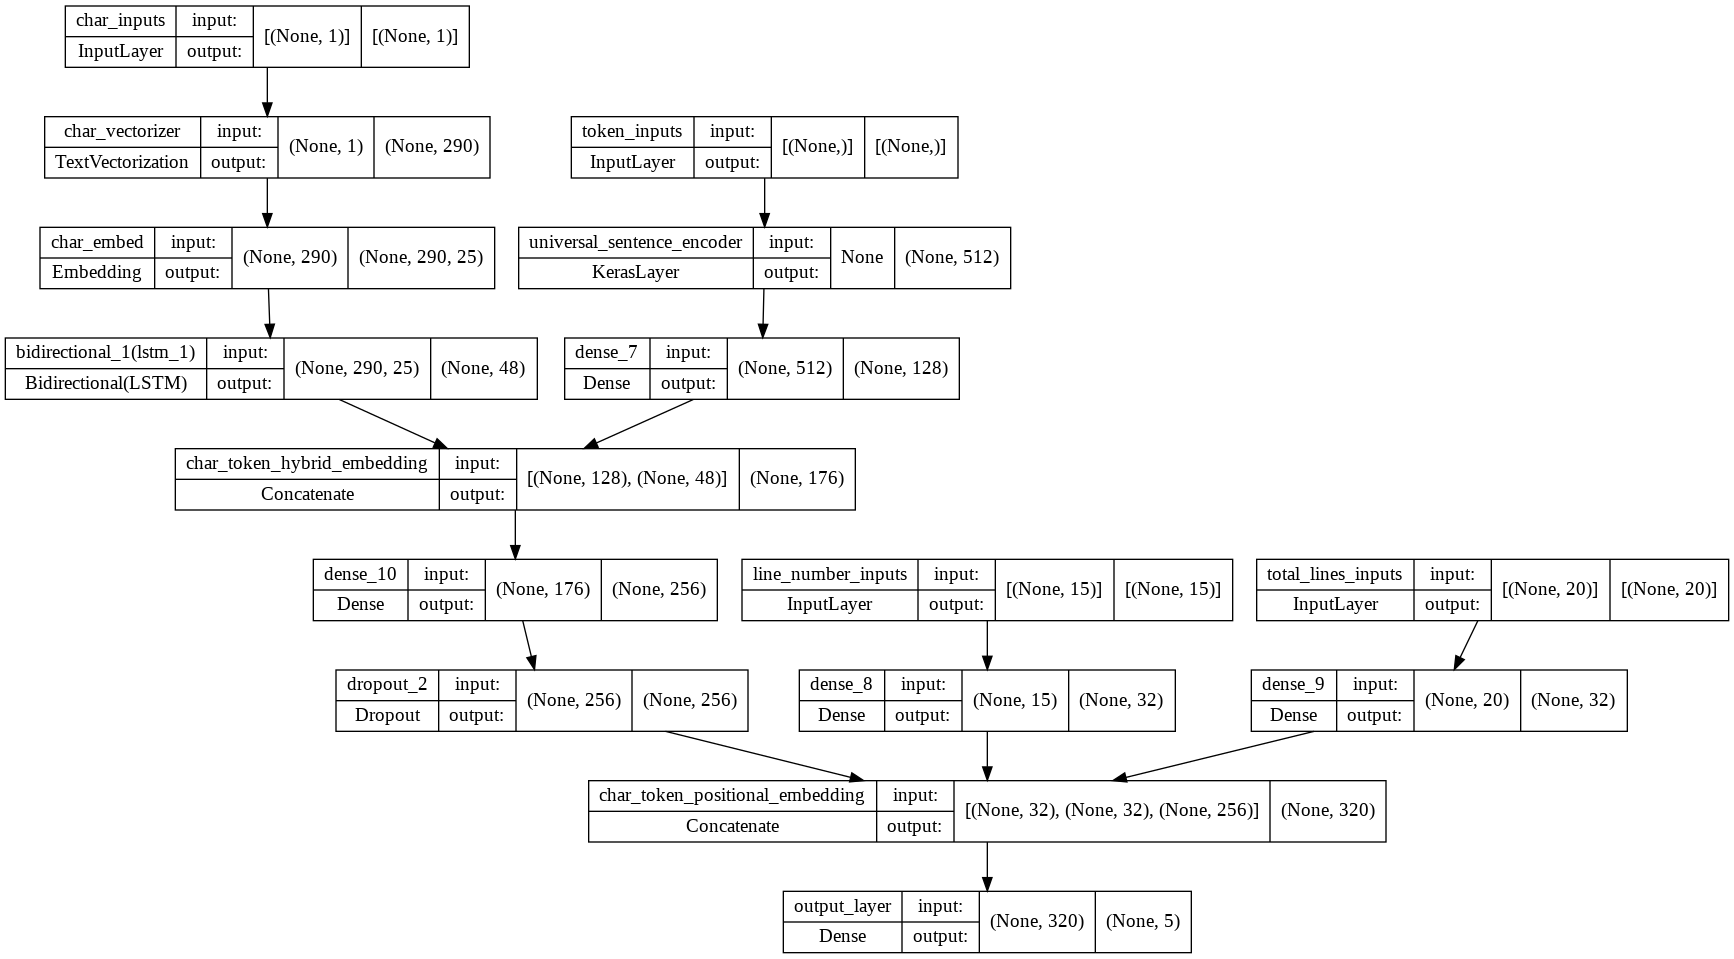

In [106]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

In [107]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [108]:
# Prepare data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars)) # order must be the same as the model
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)) # combine data and labels

# Prefetch and batch
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [109]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars)) # order must be the same as the model
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels)) # combine data and labels

# Prefetch and batch
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [110]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [111]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 60ms/step - loss: 1.0843 - accuracy: 0.7343 - val_loss: 0.9759 - val_accuracy: 0.8102
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 0.9670 - accuracy: 0.8158 - val_loss: 0.9503 - val_accuracy: 0.8245
Epoch 3/3
562/562 [==============================] - 27s 49ms/step - loss: 0.9497 - accuracy: 0.8231 - val_loss: 0.9386 - val_accuracy: 0.8311


In [112]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

array([[0.48525375, 0.11058883, 0.01311605, 0.3682645 , 0.02277692],
       [0.5290753 , 0.11020961, 0.04489985, 0.30421832, 0.0115969 ],
       [0.26801795, 0.11193191, 0.11854306, 0.4300333 , 0.07147384],
       ...,
       [0.03108429, 0.1036726 , 0.03641367, 0.02711369, 0.8017158 ],
       [0.03064061, 0.27818465, 0.07604148, 0.02911591, 0.5860174 ],
       [0.25401902, 0.52116424, 0.10809147, 0.04897126, 0.06775403]],
      dtype=float32)

In [113]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [114]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)

In [115]:
model_5_results

{'accuracy': 83.38739573679332,
 'f1': 0.8329629572803329,
 'precision': 0.8326004907531112,
 'recall': 0.8338739573679332}

## Compare model results

In [116]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.578048,0.782956,0.785780,0.783323
model_2_pretrained_token_embedding,71.620548,0.716474,0.716205,0.713136
model_3_custom_char_embedding,65.401165,0.645542,0.654012,0.644510
model_4_hybrid_char_token_embedding,73.712432,0.736234,0.737124,0.733805
model_5_pos_char_token_embedding,83.387396,0.832600,0.833874,0.832963


In [117]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

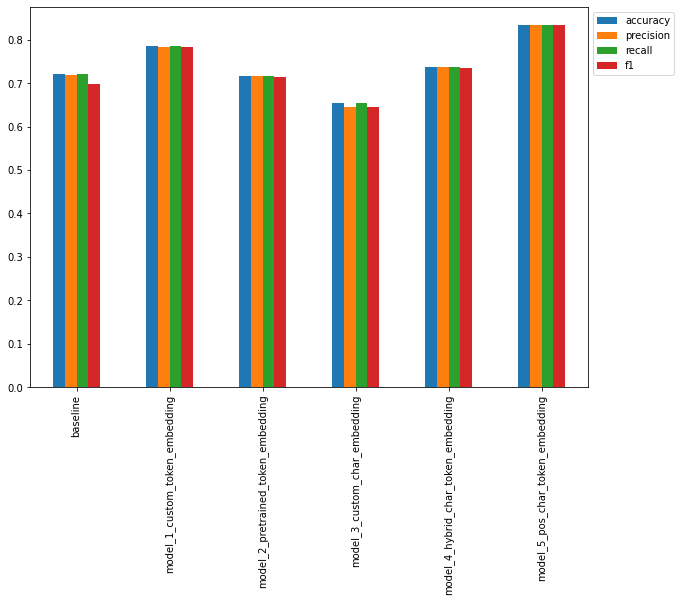

In [118]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

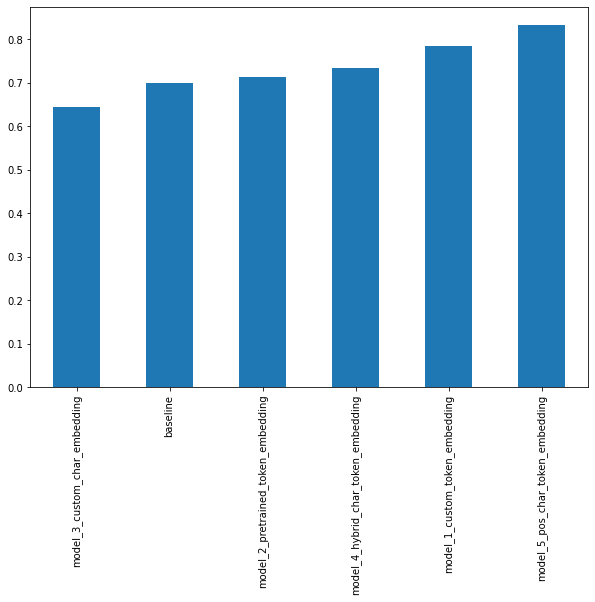

In [119]:
# Sort models by f1-score

all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7))

## Save and load model

In [120]:
model_5.save("skimlit_tribird_model")

INFO:tensorflow:Assets written to: skimlit_tribird_model/assets


INFO:tensorflow:Assets written to: skimlit_tribird_model/assets


In [121]:
loaded_model = tf.keras.models.load_model("skimlit_tribird_model")

In [122]:
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [123]:
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.38739573679332,
 'f1': 0.8329629572803329,
 'precision': 0.8326004907531112,
 'recall': 0.8338739573679332}

In [124]:
model_5_results

{'accuracy': 83.46683437044882,
 'f1': 0.8335908501340952,
 'precision': 0.8334223181227087,
 'recall': 0.8346683437044883}

In [125]:
assert model_5_results == loaded_model_results

In [126]:
import tensorflow_hub as hub
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2022-07-19 03:08:51--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  69.1MB/s    in 14s     

2022-07-19 03:09:05 (67.1 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_m

In [127]:
loaded_gs_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model/")

AssertionError: ignored

In [ ]:
loaded_gs_model.evaluate(val_char_token_pos_dataset)

## 1 Using callbacks

In [128]:
checkpint_filepath = "best_weigths/checkpoint"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True,
    save_freq="epoch"
)

In [129]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                           patience=3,
                                                           verbose=1,
                                                           min_delta=0.5)

In [130]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.fit(train_char_token_pos_dataset,
            epochs=40,
            validation_data=val_char_token_pos_dataset,
            callbacks=[model_checkpoint_callback,
                       early_stopping_callback])

Epoch 1/40
5627/5627 [==============================] - 312s 53ms/step - loss: 0.9237 - accuracy: 0.8439 - val_loss: 0.9018 - val_accuracy: 0.8527
Epoch 2/40
5627/5627 [==============================] - 340s 60ms/step - loss: 0.9031 - accuracy: 0.8580 - val_loss: 0.8959 - val_accuracy: 0.8554
Epoch 3/40
5627/5627 [==============================] - 308s 55ms/step - loss: 0.8923 - accuracy: 0.8668 - val_loss: 0.8919 - val_accuracy: 0.8584
Epoch 4/40
5627/5627 [==============================] - 416s 74ms/step - loss: 0.8839 - accuracy: 0.8722 - val_loss: 0.8928 - val_accuracy: 0.8579
Epoch 4: early stopping


## 2 Using GloVe embeddings

In [131]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-07-19 03:37:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-19 03:37:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-19 03:37:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [132]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [149]:
# Creatinga a text vectorizaiton layer (68k vocab size from the paper itself)
from tensorflow.keras.layers import TextVectorization 

new_text_vectorizer = TextVectorization(max_tokens= 68000 , 
                                    output_sequence_length = 56)

# Adapt our text vectorizer to training sentences

new_text_vectorizer.adapt(train_sentences)

In [150]:
voc = new_text_vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
len(voc)

64841

In [151]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # This is is the word found in embedding index
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses+=1

print("Converted %d words (%d misses)" % (hits, misses))

Converted 29730 words (35111 misses)


In [152]:
from tensorflow.keras.layers import Embedding

glove_embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
)

In [160]:
# Build a model
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = glove_embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu", padding = "same")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu", padding = "same")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu", padding = "same")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(num_classes, activation="softmax")(x)
glove_model = tf.keras.Model(int_sequences_input, preds)
glove_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         6484300   
                                                                 
 conv1d_14 (Conv1D)          (None, None, 128)         64128     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                     

In [161]:
# Prepare data
train_sen_vectors = new_text_vectorizer(np.array([[sen] for sen in train_sentences])).numpy()
val_sen_vectors = new_text_vectorizer(np.array([[sen] for sen in val_sentences])).numpy()

train_ds = tf.data.Dataset.from_tensor_slices((train_sen_vectors, train_labels_encoded))
val_ds = tf.data.Dataset.from_tensor_slices((val_sen_vectors, val_labels_encoded))

train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [155]:
train_sen_vectors[0].shape

(56,)

In [156]:
train_ds, val_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 56), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 56), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [162]:
glove_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

glove_model.fit(train_ds,
                epochs=3,
                validation_data=val_ds)

Epoch 1/3
5627/5627 [==============================] - 28s 5ms/step - loss: 0.6540 - accuracy: 0.7574 - val_loss: 0.5566 - val_accuracy: 0.7927
Epoch 2/3
5627/5627 [==============================] - 26s 5ms/step - loss: 0.5263 - accuracy: 0.8085 - val_loss: 0.5577 - val_accuracy: 0.8032
Epoch 3/3
5627/5627 [==============================] - 26s 5ms/step - loss: 0.4841 - accuracy: 0.8242 - val_loss: 0.5220 - val_accuracy: 0.8133


## 3 Using BERT PubMed expert

In [167]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 13.8 MB/s 
     |████████████████████████████████| 511.7 MB 6.5 kB/s 
     |████████████████████████████████| 438 kB 70.5 MB/s 
     |████████████████████████████████| 5.8 MB 58.6 MB/s 
     |████████████████████████████████| 1.6 MB 59.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [2]:
import tensorflow_hub as hub
import tensorflow_text as text
bert_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/experts/bert/pubmed/2",
                                        trainable=False,
                                        name="experts_bert_pubmed_layer")
bert_preprocess_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
                            trainable=False,
                            name="bert_preprocess_layer")

In [37]:
input = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = bert_preprocess_layer(input)
x = bert_embedding_layer(x)
x = layers.Dense(128, activation="relu")(x["pooled_output"])
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation="softmax")(x)
bert_model = tf.keras.Model(input, output)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 bert_preprocess_layer (KerasLa  {'input_mask': (Non  0          ['input_1[0][0]']                
 yer)                           e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [38]:
train_sen_ds = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
val_sen_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))

train_sen_ds = train_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_sen_ds = val_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
bert_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

In [44]:
bert_model.fit(train_sen_ds,
               steps_per_epoch=int(0.1*len(train_sen_ds)),
               epochs=3,
               validation_data=val_sen_ds,
               validation_steps=int(0.1*len(val_sen_ds)))

Epoch 1/3
562/562 [==============================] - 214s 381ms/step - loss: 0.6195 - accuracy: 0.7898 - val_loss: 0.4506 - val_accuracy: 0.8451
Epoch 2/3
562/562 [==============================] - 213s 378ms/step - loss: 0.5109 - accuracy: 0.8216 - val_loss: 0.4524 - val_accuracy: 0.8314
Epoch 3/3
562/562 [==============================] - 213s 379ms/step - loss: 0.5035 - accuracy: 0.8250 - val_loss: 0.4165 - val_accuracy: 0.8567


## 4 X_of_Y

In [150]:
train_x_y_proportion = train_df["line_number"]/train_df["total_lines"]
val_x_y_proportion = val_df["line_number"]/val_df["total_lines"]
test_x_y_proportion = test_df["line_number"]/test_df["total_lines"]

In [139]:
train_x_y_proportion.shape # this is DataFrame

(30135,)

In [127]:
train_x_y_proportion.value_counts()

0.000000    15000
1.000000    15000
0.500000     7432
0.666667     5022
0.333333     5022
            ...  
0.703704        1
0.740741        1
0.814815        1
0.851852        1
0.966667        1
Length: 251, dtype: int64

In [130]:
train_x_y_df = pd.DataFrame({"proportion": train_x_y_proportion})
train_x_y_df

,proportion
0,0.000000
1,0.090909
2,0.181818
3,0.272727
4,0.363636
...,...
180035,0.636364
180036,0.727273
180037,0.818182
180038,0.909091


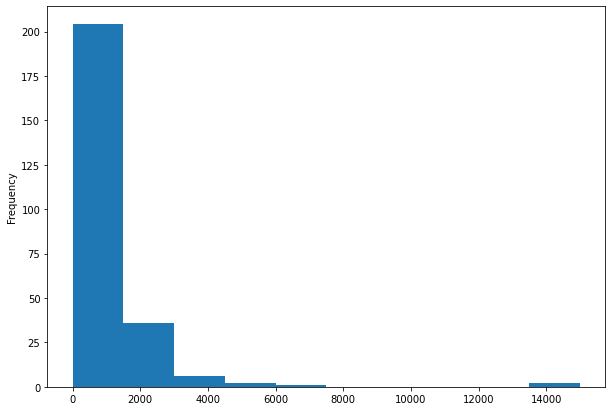

In [132]:
train_x_y_df["proportion"].value_counts().plot(figsize=(10,7), kind="hist")

In [134]:
np.percentile(train_x_y_df.proportion, 90)

0.9230769230769231

In [136]:
train_x_y_proportion.shape

(30135,)

In [151]:
train_x_y_proportion = train_x_y_proportion.tolist()
val_x_y_proportion = val_x_y_proportion.tolist()
test_x_y_proportion = test_x_y_proportion.tolist()

In [156]:
type(train_x_y_proportion[0])

float

In [161]:
# tribrid model

# Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# X_of_Y model (line_number/total_lines)
x_y_inputs = layers.Input(shape=[], dtype=tf.float64, name="x_of_y_layer")
x = layers.Dense(32, activation="relu")(tf.expand_dims(x_y_inputs, axis=1))
x_y_prop_model = tf.keras.Model(inputs=x_y_inputs,
                                outputs=x)

# combine token and char embeddings
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(x_y_prop_model.output)

# make a model
model_6 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 x_y_prop_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding")

In [165]:
# Prepare data
train_char_token_prop_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                                train_chars,
                                                                train_x_y_proportion))
train_char_token_prop_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_prop_dataset = tf.data.Dataset.zip((train_char_token_prop_data, train_char_token_prop_labels))
train_char_token_prop_dataset = train_char_token_prop_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [166]:
# Prepare data
val_char_token_prop_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                                val_chars,
                                                                val_x_y_proportion))
val_char_token_prop_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_prop_dataset = tf.data.Dataset.zip((val_char_token_prop_data, val_char_token_prop_labels))
val_char_token_prop_dataset = val_char_token_prop_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [167]:
model_6.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [168]:
model_6.fit(train_char_token_prop_dataset,
            steps_per_epoch=int(0.1*len(train_char_token_prop_dataset)),
            epochs=3,
            validation_data=val_char_token_prop_dataset,
            validation_steps=int(0.1*len(val_char_token_prop_dataset)))

Epoch 1/3
562/562 [==============================] - 3s 5ms/step - loss: 1.3033 - accuracy: 0.4927 - val_loss: 1.1455 - val_accuracy: 0.5426
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0613 - accuracy: 0.5664 - val_loss: 0.9910 - val_accuracy: 0.6177
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9521 - accuracy: 0.6378 - val_loss: 0.9155 - val_accuracy: 0.6858


In [169]:
model_6_pred_probs = model_6.predict(val_char_token_prop_dataset)

In [180]:
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 1, 1])>

In [178]:
model_6_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_6_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5 make predictions

In [181]:
# Getting the example abstract to test our function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2022-07-20 03:40:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-07-20 03:40:53 (67.0 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [182]:
import json
with open("skimlit_example_abstracts.json", "r") as f:
  ex_abstract = json.load(f)

ex_abstract

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum 

In [198]:
print(ex_abstract[0]["abstract"])

This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


In [194]:
type(ex_abstract[0])

dict

In [204]:
for elm in ex_abstract:
  text = elm["abstract"]
  text_list = text.split(".")
  print(len(text_list))
  for txt in text_list:
    print(txt)
  print(text_list[0])
  print(type(text_list[0]))

9
This RCT examined the efficacy of a manualized social intervention for children with HFASDs
 Participants were randomly assigned to treatment or wait-list conditions
 Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language
 A response-cost program was applied to reduce problem behaviors and foster skills acquisition
 Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures)
 Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents
 High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity
 Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group

This RCT examined the efficacy of a manualized social intervention for children with HFASDs
<class 'str

In [213]:
from tensorflow.python.ops.gen_dataset_ops import text_line_dataset
def predict_and_label(abstract_text, model, label_encoder):
  """
  Args:
    abstract_dict : dictionary with key=label and element=texts
    model : trained model to use for prediction
    label_enocder : use this to encode classes
  """
  text_list = abstract_text.split(".")
  del text_list[-1] # remove the last element because its basically empty
  
  total_lines = len(text_list)

  # split each line and label line number
  sample_lines=[] # this list is going to contain dictionary
  for i, line in enumerate(text_list):
    line_dict = {}
    line_dict["text"] = line
    line_dict["line_number"] = i
    line_dict["total_lines"] = total_lines
    sample_lines.append(line_dict)

  abstract_line_num = [line["line_number"] for line in sample_lines]
  abstract_total_lines = [line["total_lines"] for line in sample_lines]

  abstract_line_num_one_hot = tf.one_hot(abstract_line_num, depth=15)
  abstract_total_lines_one_hot = tf.one_hot(abstract_total_lines, depth=20)

  # Split into characters
  abstract_chars = [split_chars(sentence) for sentence in text_list]

  abstract_pred_probs = model.predict(x = (abstract_line_num_one_hot,
                                           abstract_total_lines_one_hot,
                                           tf.constant(text_list),
                                           tf.constant(abstract_chars)))
  
  preds = tf.argmax(abstract_pred_probs, axis=1)

  pred_classes = [label_encoder.classes_[i] for i in preds]

  for i, line in enumerate(text_list):
    print(f"{pred_classes[i]} : {line}\n")

In [218]:
predict_and_label(ex_abstract[0]["abstract"], model_5, label_encoder)

OBJECTIVE : This RCT examined the efficacy of a manualized social intervention for children with HFASDs

METHODS :  Participants were randomly assigned to treatment or wait-list conditions

METHODS :  Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language

METHODS :  A response-cost program was applied to reduce problem behaviors and foster skills acquisition

METHODS :  Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures)

METHODS :  Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents

RESULTS :  High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity

RESULTS :  Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group

